In [1]:
import openai
import numpy as np
from sentence_transformers import SentenceTransformer
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import torch
import torch.nn.functional as F
from torch import Tensor
from transformers import AutoTokenizer, AutoModel

client = openai.OpenAI(api_key="sk-proj-7MAfZbOm9lPY28pubTiRT3BlbkFJGgn73o5e6sVCjoTfoFAP")
MODEL = "gpt-4o"

##################################################
def get_full_response(prompt, n=1, max_tokens=1000, temperature=0.7, top_p=1.0, frequency_penalty=0.0, presence_penalty=0.0):
    for _ in range(n):
        response = client.chat.completions.create(
            model="gpt-4-turbo",  # Replace with your model ID as needed
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p,
            frequency_penalty=frequency_penalty,
            presence_penalty=presence_penalty,
            logprobs=True,  # Enable logprobs
            top_logprobs=10  # Specify number of top log probabilities to return
        )

        # Print the entire response object
        return response
        
##################################################
def extract_chat_completion_data(response):
    # Data structure to hold the results
    data = {
        "Response Content": "",
        "Logprobs": [],
        "Top Logprob Words": [],
        "Top Logprob Values": []
    }
    
    # Assume the first choice for simplification; adapt as needed for multiple choices
    if response.choices:
        choice = response.choices[0]
        data["Response Content"] = choice.message.content
        
        # Extract token logprob information
        for token_logprob in choice.logprobs.content:
            # Append the logprob of the current token to the list
            data["Logprobs"].append(token_logprob.logprob)
            
            # For collecting top logprob words and their values
            top_words = []
            top_values = []
            
            # Extract top logprob details
            for top_logprob in token_logprob.top_logprobs:
                top_words.append(top_logprob.token)
                top_values.append(top_logprob.logprob)
            
            # Append each token's top logprob words and values
            data["Top Logprob Words"].append(top_words)
            data["Top Logprob Values"].append(top_values)

    return data

##################################################
def parse_conversations(file_path):
    with open(file_path, 'r') as file:
        content = file.read()

    conversations = content.split('\n\n')
    user_messages = []
    chatgpt_messages = []

    current_label = None
    current_message = []

    for conversation in conversations:
        lines = conversation.strip().split('\n')
        if len(lines) >= 1:
            if lines[0] == '#USER':
                if current_label == '##ChatGPT':
                    chatgpt_messages.append(' '.join(current_message))
                current_label = '#USER'
                current_message = lines[1:]
            elif lines[0] == '##ChatGPT':
                if current_label == '#USER':
                    user_messages.append(' '.join(current_message))
                current_label = '##ChatGPT'
                current_message = lines[1:]
            else:
                current_message.extend(lines)

    if current_label == '#USER':
        user_messages.append(' '.join(current_message))
    elif current_label == '##ChatGPT':
        chatgpt_messages.append(' '.join(current_message))

    return user_messages, chatgpt_messages

##################################################
def train_autoencoder(input_data, latent_dim,num_epochs):
    encoder_input = tf.keras.Input(shape=(input_data.shape[-1],))
    encoded = tf.keras.layers.Dense(512, activation='relu')(encoder_input)
    encoded = tf.keras.layers.Dropout(0.5)(encoded)
    encoded = tf.keras.layers.Dense(256, activation='relu')(encoded)
    encoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
    encoded_output = tf.keras.layers.Dense(latent_dim, activation='linear')(encoded)

    encoder = tf.keras.Model(encoder_input, encoded_output, name='encoder')

    decoder_input = tf.keras.Input(shape=(latent_dim,))
    decoded = tf.keras.layers.Dense(128, activation='relu')(decoder_input)
    decoded = tf.keras.layers.Dense(256, activation='relu')(decoded)
    decoded = tf.keras.layers.Dense(512, activation='relu')(decoded)
    decoded_output = tf.keras.layers.Dense(input_data.shape[-1], activation='sigmoid')(decoded)

    decoder = tf.keras.Model(decoder_input, decoded_output, name='decoder')

    autoencoder_input = encoder_input
    encoded_embedding = encoder(autoencoder_input)
    decoded_embedding = decoder(encoded_embedding)

    autoencoder = tf.keras.Model(autoencoder_input, decoded_embedding, name='autoencoder')
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

    autoencoder.fit(input_data, input_data, epochs=num_epochs, batch_size=16, verbose=1)
    return encoder

##################################################
def visualize_2d_grid(encoded_2d_grid, grid_size):
    # Applying Gaussian filter to smooth the grids
    smoothed_grids = np.array([gaussian_filter(grid, sigma=2) for grid in encoded_2d_grid])

    # Setting up the figure and 3D axis
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Creating a meshgrid for the x and y coordinates
    X, Y = np.meshgrid(range(grid_size), range(grid_size))
    
    # Plotting each grid with an increasing offset in Z
    offset = 0.0
    for i in range(smoothed_grids.shape[0]):
        Z = smoothed_grids[i] + i * offset  # Offset each grid
        ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)

    # Setting labels and title
    ax.set_title('3D Visualization of Smoothed Text Embeddings')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Embedding Value')

    # Display the plot
    plt.show()
    
##################################################
def pad_token_probs(probabilities, pad_value=0):
    # Find the maximum length of the token probabilities list
    max_length = max(len(probs) for probs in probabilities)
    # Pad each probabilities list to the maximum length
    padded_probabilities = np.array([np.pad(probs, (0, max_length - len(probs)), 'constant', constant_values=pad_value) for probs in probabilities])
    return padded_probabilities

##################################################
def embed_text(input_texts,max_length=500):
    try:
        # Tokenize the input texts
        batch_dict = tokenizer(input_texts, max_length=max_length, padding=True, truncation=True, return_tensors='pt').to(device)
        
        # Set output_hidden_states to True
        outputs = model(**batch_dict, output_hidden_states=True)
        
        # Use the new pooling method
        embeddings = multi_layer_pool(outputs.hidden_states, batch_dict['attention_mask'])
        
        # Normalize embeddings
        embeddings = F.normalize(embeddings, p=2, dim=1)
        
        # Convert the embeddings to lists
        embedding_lists = embeddings.cpu().tolist()
        
        return embedding_lists
    
    except Exception as e:
        print(f"An error occurred: {e}")
    
    finally:
        # Clear the GPU memory
        del batch_dict
        del outputs
        del embeddings
        torch.cuda.empty_cache()

##################################################
def multi_layer_pool(hidden_states: list, attention_mask: Tensor, num_layers: int = 1) -> Tensor:
    """
    Extract embeddings from the last 'num_layers' layers and concatenate them.
    """
    # Get the last num_layers layers
    all_layers = hidden_states[-num_layers:]  
    # Concatenate them on the embedding dimension
    concatenated_layers = torch.cat(all_layers, dim=-1)  

    left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
    if left_padding:
        return concatenated_layers[:, -1]
    else:
        sequence_lengths = attention_mask.sum(dim=1) - 1
        batch_size = concatenated_layers.shape[0]
        return concatenated_layers[torch.arange(batch_size, device=concatenated_layers.device), sequence_lengths]


2024-05-18 00:16:36.323978: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-18 00:16:36.327229: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-18 00:16:36.368604: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-18 00:16:37.258177: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained('intfloat/e5-mistral-7b-instruct')
model = AutoModel.from_pretrained('intfloat/e5-mistral-7b-instruct').to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
file_path = './breakingchat.txt'
user_list, chatgpt_list = parse_conversations(file_path)

In [ ]:
embedding_user_list = []
embedding_chatgpt_list = []
max_input_text_len = 1000
for text in user_list:
    embedding_user_list.append(embed_text(text[0:max_input_text_len]))
for text in chatgpt_list:
    embedding_chatgpt_list.append(embed_text(text[0:max_input_text_len]))

In [ ]:
from sentence_transformers import SentenceTransformer

def get_embeddings(texts):
    model = SentenceTransformer('sentence-transformers/paraphrase-mpnet-base-v2')
    embeddings = model.encode(texts, show_progress_bar=True)
    return embeddings
# Note: You might need to limit the number of texts processed at once if the list is very large
embedding_user_list = get_embeddings(user_list[:max_input_text_len])
embedding_chatgpt_list = get_embeddings(chatgpt_list[:max_input_text_len])
import numpy as np

# Calculate variance for each set of embeddings
user_variance = np.var(embedding_user_list, axis=0).mean()
chatgpt_variance = np.var(embedding_chatgpt_list, axis=0).mean()

print(f"Mean Variance in User Embeddings: {user_variance}")
print(f"Mean Variance in ChatGPT Embeddings: {chatgpt_variance}")

from sentence_transformers import SentenceTransformer

def get_embeddings(texts):
    model = SentenceTransformer('sentence-transformers/paraphrase-mpnet-base-v2')
    embeddings = model.encode(texts, show_progress_bar=True)
    return embeddings

# Assuming `user_list` and `chatgpt_list` contain your texts
embedding_user_array = get_embeddings(user_list[:max_input_text_len])
embedding_chatgpt_array = get_embeddings(chatgpt_list[:max_input_text_len])

# Ensure both arrays are of the same shape
if embedding_user_array.shape[1] != embedding_chatgpt_array.shape[1]:
    raise ValueError("Embedding dimensions do not match and cannot be concatenated.")

# Here we use only ChatGPT array for training as an example
combined_input = embedding_chatgpt_array

grid_size = 30
latent_dim = grid_size * grid_size

# Train the autoencoder
encoder = train_autoencoder(combined_input, latent_dim, 30)

# Predict using the trained encoder
encoded_2d_grid = encoder.predict(combined_input).reshape(-1, grid_size, grid_size)
print("Variance in Encoded Outputs for ChatGPT Data:", np.var(encoded_2d_grid, axis=0).mean())
visualize_2d_grid(encoded_2d_grid, grid_size)

# Now predict using user data
combined_input = embedding_user_array
encoded_2d_grid = encoder.predict(combined_input).reshape(-1, grid_size, grid_size)
print("Variance in Encoded Outputs for User Data:", np.var(encoded_2d_grid, axis=0).mean())
visualize_2d_grid(encoded_2d_grid, grid_size)



In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def single_layer_pool(hidden_states, layer_index):
    """
    Extract embeddings from a specific layer.
    """
    selected_layer = hidden_states[layer_index]
    return selected_layer.mean(dim=1)  # Average over the token dimension to get a single vector per sequence

def embed_text(input_texts, max_length=500, layer_index=-1, scaling_factor=1.0):
    try:
        # Tokenize the input texts with truncation and without padding
        batch_dict = tokenizer(input_texts, max_length=max_length, padding=False, truncation=True, return_tensors='pt').to(device)
        
        # Check the length of the tokenized input and ignore if it's less than 100
        token_length = batch_dict['input_ids'].shape[1]
        if token_length < 100:
            return None
        
        # Set output_hidden_states to True
        outputs = model(**batch_dict, output_hidden_states=True)
        
        # Use the new pooling method with specified layer
        embeddings = single_layer_pool(outputs.hidden_states, layer_index)
        
        # Normalize embeddings
        embeddings = F.normalize(embeddings, p=2, dim=1)
        
        # Scale embeddings
        embeddings = embeddings * scaling_factor
        
        # Convert the embeddings to lists
        embedding_lists = embeddings.cpu().tolist()
        
        return embedding_lists
    
    except Exception as e:
        print(f"An error occurred: {e}")
    
    finally:
        try:
            del batch_dict
            del outputs
            del embeddings
            torch.cuda.empty_cache()
        except:
            pass

max_input_text_len = 500  # Set a specific maximum length for truncation
min_input_text_len = 100  # Minimum length threshold
layer_index = -1  # Use the last layer by default
scaling_factor = 1000.0  # Scaling factor to amplify the embedding values

print("Analyzing User Texts")
embedding_user_list = []
for text in user_list:
    embeddings = embed_text(text, max_length=max_input_text_len, layer_index=layer_index, scaling_factor=scaling_factor)
    if embeddings is not None:
        embedding_user_list.append(embeddings)

print("Analyzing ChatGPT Texts")
embedding_chatgpt_list = []
for text in chatgpt_list:
    embeddings = embed_text(text, max_length=max_input_text_len, layer_index=layer_index, scaling_factor=scaling_factor)
    if embeddings is not None:
        embedding_chatgpt_list.append(embeddings)

# Convert lists of lists to numpy arrays
embedding_user_array = np.array(embedding_user_list)
embedding_chatgpt_array = np.array(embedding_chatgpt_list)

# Calculate variances
user_variance = np.var(embedding_user_array, axis=0).mean()
chatgpt_variance = np.var(embedding_chatgpt_array, axis=0).mean()

print(f"Mean Variance in User Embeddings: {user_variance}")
print(f"Mean Variance in ChatGPT Embeddings: {chatgpt_variance}")


Analyzing User Texts
Analyzing ChatGPT Texts
Mean Variance in User Embeddings: 0.19206727013189573
Mean Variance in ChatGPT Embeddings: 0.12630025686847687
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 2.7193
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Variance in Encoded Outputs for ChatGPT Data: 0.016024793


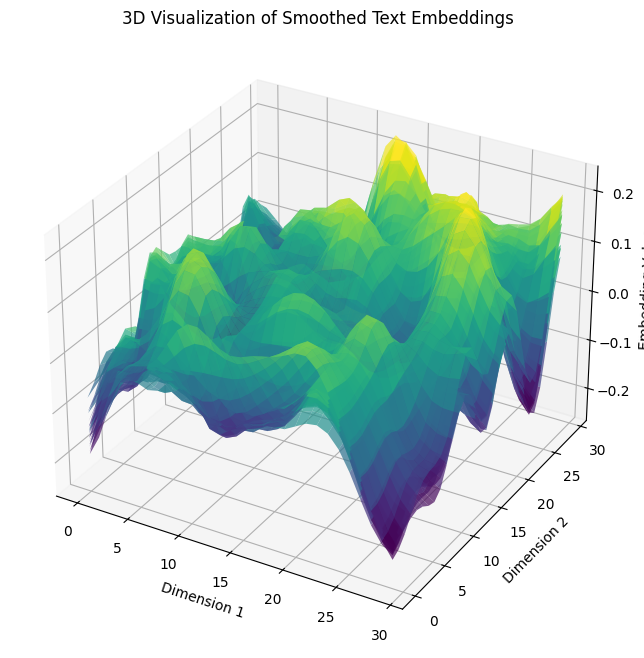

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Variance in Encoded Outputs for User Data: 0.020248353


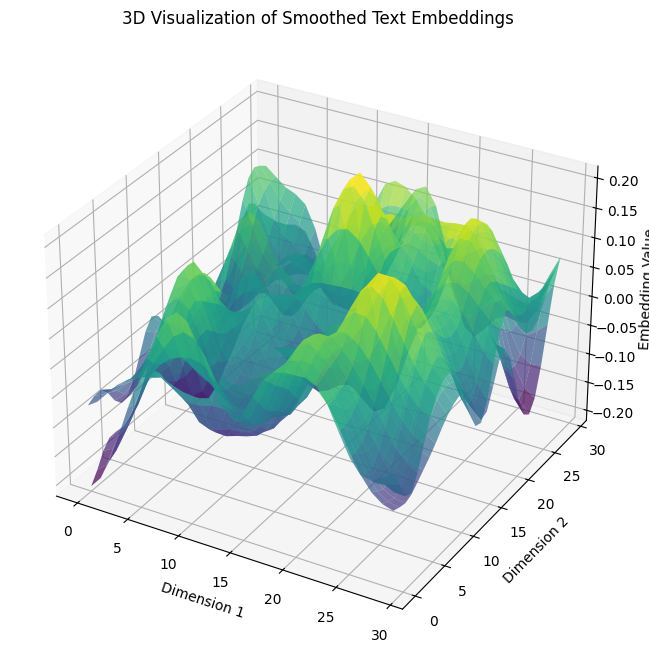

In [20]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def single_layer_pool(hidden_states, layer_index):
    """
    Extract embeddings from a specific layer.
    """
    selected_layer = hidden_states[layer_index]
    return selected_layer.mean(dim=1)  # Average over the token dimension to get a single vector per sequence

def embed_text(input_texts, max_length=500, layer_index=-1, scaling_factor=1.0):
    try:
        # Tokenize the input texts with truncation and without padding
        batch_dict = tokenizer(input_texts, max_length=max_length, padding=False, truncation=True, return_tensors='pt').to(device)
        
        # Check the length of the tokenized input and ignore if it's less than 100
        token_length = batch_dict['input_ids'].shape[1]
        if token_length < 100:
            return None
        
        # Set output_hidden_states to True
        outputs = model(**batch_dict, output_hidden_states=True)
        
        # Use the new pooling method with specified layer
        embeddings = single_layer_pool(outputs.hidden_states, layer_index)
        
        # Normalize embeddings
        embeddings = F.normalize(embeddings, p=2, dim=1)
        
        # Scale embeddings
        embeddings = embeddings * scaling_factor
        
        # Convert the embeddings to lists
        embedding_lists = embeddings.cpu().tolist()
        
        return embedding_lists
    
    except Exception as e:
        print(f"An error occurred: {e}")
    
    finally:
        try:
            del batch_dict
            del outputs
            del embeddings
            torch.cuda.empty_cache()
        except:
            pass

max_input_text_len = 500  # Set a specific maximum length for truncation
min_input_text_len = 100  # Minimum length threshold
layer_index = -1  # Use the last layer by default
scaling_factor = 100.0  # Scaling factor to amplify the embedding values

print("Analyzing User Texts")
embedding_user_list = []
for text in user_list:
    embeddings = embed_text(text, max_length=max_input_text_len, layer_index=layer_index, scaling_factor=scaling_factor)
    if embeddings is not None:
        embedding_user_list.append(embeddings)

print("Analyzing ChatGPT Texts")
embedding_chatgpt_list = []
for text in chatgpt_list:
    embeddings = embed_text(text, max_length=max_input_text_len, layer_index=layer_index, scaling_factor=scaling_factor)
    if embeddings is not None:
        embedding_chatgpt_list.append(embeddings)

# Convert lists of lists to numpy arrays and reshape to remove the extra dimension
embedding_user_array = np.squeeze(np.array(embedding_user_list), axis=1)
embedding_chatgpt_array = np.squeeze(np.array(embedding_chatgpt_list), axis=1)

# Calculate variances
user_variance = np.var(embedding_user_array, axis=0).mean()
chatgpt_variance = np.var(embedding_chatgpt_array, axis=0).mean()

print(f"Mean Variance in User Embeddings: {user_variance}")
print(f"Mean Variance in ChatGPT Embeddings: {chatgpt_variance}")

# Assume the following functions and imports are provided
import tensorflow as tf

def train_autoencoder(input_data, latent_dim, num_epochs):
    encoder_input = tf.keras.Input(shape=(input_data.shape[-1],))
    
    # Encoder configuration
    encoded = tf.keras.layers.Dense(1024, activation='relu')(encoder_input)
    encoded = tf.keras.layers.BatchNormalization()(encoded)
    encoded = tf.keras.layers.LeakyReLU()(encoded)
    encoded = tf.keras.layers.Dense(512, activation='relu')(encoded)
    encoded = tf.keras.layers.Dropout(0.3)(encoded)
    encoded = tf.keras.layers.Dense(256, activation='relu')(encoded)
    encoded = tf.keras.layers.BatchNormalization()(encoded)
    encoded = tf.keras.layers.LeakyReLU()(encoded)
    encoded_output = tf.keras.layers.Dense(latent_dim, activation='linear')(encoded)

    encoder = tf.keras.Model(encoder_input, encoded_output, name='encoder')

    # Decoder configuration
    decoder_input = tf.keras.Input(shape=(latent_dim,))
    decoded = tf.keras.layers.Dense(256, activation='relu')(decoder_input)
    decoded = tf.keras.layers.BatchNormalization()(decoded)
    decoded = tf.keras.layers.LeakyReLU()(decoded)
    decoded = tf.keras.layers.Dense(512, activation='relu')(decoded)
    decoded = tf.keras.layers.Dropout(0.3)(decoded)
    decoded = tf.keras.layers.Dense(1024, activation='relu')(decoded)
    decoded = tf.keras.layers.BatchNormalization()(decoded)
    decoded = tf.keras.layers.LeakyReLU()(decoded)
    decoded_output = tf.keras.layers.Dense(input_data.shape[-1], activation='sigmoid')(decoded)

    decoder = tf.keras.Model(decoder_input, decoded_output, name='decoder')

    # Autoencoder connecting encoder and decoder
    autoencoder_input = encoder_input
    encoded_embedding = encoder(autoencoder_input)
    decoded_embedding = decoder(encoded_embedding)
    autoencoder = tf.keras.Model(autoencoder_input, decoded_embedding, name='autoencoder')
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

    # Train the autoencoder
    autoencoder.fit(input_data, input_data, epochs=num_epochs, batch_size=32, verbose=1)
    return encoder

def visualize_2d_grid(encoded_2d_grid, grid_size):
    # Applying Gaussian filter to smooth the grids
    smoothed_grids = np.array([gaussian_filter(grid, sigma=2) for grid in encoded_2d_grid])

    # Setting up the figure and 3D axis
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Creating a meshgrid for the x and y coordinates
    X, Y = np.meshgrid(range(grid_size), range(grid_size))
    
    # Plotting each grid with an increasing offset in Z
    offset = 0.0
    for i in range(smoothed_grids.shape[0]):
        Z = smoothed_grids[i] + i * offset  # Offset each grid
        ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)

    # Setting labels and title
    ax.set_title('3D Visualization of Smoothed Text Embeddings')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Embedding Value')

    # Display the plot
    plt.show()

# Train the autoencoder and visualize embeddings
grid_size = 30
latent_dim = grid_size * grid_size
num_epochs = 1

combined_input = embedding_chatgpt_array
encoder = train_autoencoder(combined_input, latent_dim, num_epochs)

# Predict using the trained encoder
encoded_2d_grid = encoder.predict(combined_input).reshape(-1, grid_size, grid_size)
print("Variance in Encoded Outputs for ChatGPT Data:", np.var(encoded_2d_grid, axis=0).mean())
visualize_2d_grid(encoded_2d_grid, grid_size)

# Now predict using user data
combined_input = embedding_user_array
encoded_2d_grid = encoder.predict(combined_input).reshape(-1, grid_size, grid_size)
print("Variance in Encoded Outputs for User Data:", np.var(encoded_2d_grid, axis=0).mean())
visualize_2d_grid(encoded_2d_grid, grid_size)


Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 2.7212
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - loss: 2.7078
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - loss: 2.6946
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 2.6818
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 2.6689
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step - loss: 2.6544
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - loss: 2.6410
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 2.6289
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 2.6151
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - loss: 2.6015
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 2.5874
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - loss: 2.5741
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - loss: 2.5623
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - loss: 2.5485
Epoch 15/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 2.5348
Epoch 1

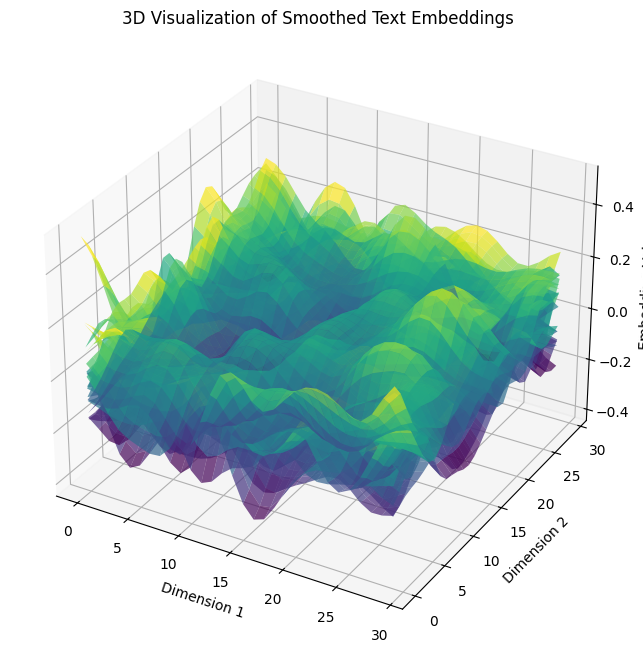

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Variance in Encoded Outputs for User Data: 0.2940069


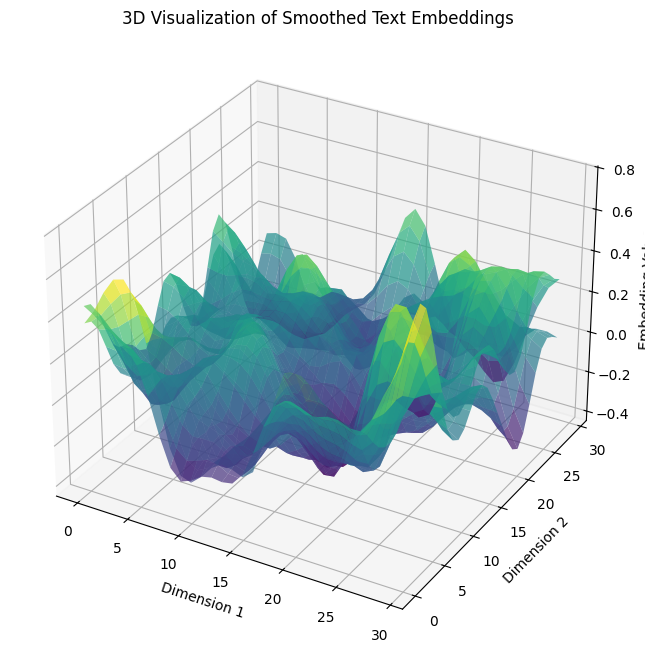

In [21]:
# Train the autoencoder and visualize embeddings
grid_size = 30
latent_dim = grid_size * grid_size
num_epochs = 500

combined_input = embedding_chatgpt_array
encoder = train_autoencoder(combined_input, latent_dim, num_epochs)

# Predict using the trained encoder
encoded_2d_grid = encoder.predict(combined_input).reshape(-1, grid_size, grid_size)
print("Variance in Encoded Outputs for ChatGPT Data:", np.var(encoded_2d_grid, axis=0).mean())
visualize_2d_grid(encoded_2d_grid, grid_size)

# Now predict using user data
combined_input = embedding_user_array
encoded_2d_grid = encoder.predict(combined_input).reshape(-1, grid_size, grid_size)
print("Variance in Encoded Outputs for User Data:", np.var(encoded_2d_grid, axis=0).mean())
visualize_2d_grid(encoded_2d_grid, grid_size)

In [12]:
print(len(embedding_chatgpt_array))

17


In [23]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#tokenizer = AutoTokenizer.from_pretrained('intfloat/e5-mistral-7b-instruct')
#model = AutoModel.from_pretrained('intfloat/e5-mistral-7b-instruct').to(device)

def single_layer_pool(hidden_states, layer_index):
    """
    Extract embeddings from a specific layer.
    """
    selected_layer = hidden_states[layer_index]
    return selected_layer.mean(dim=1)  # Average over the token dimension to get a single vector per sequence

def embed_text(input_texts, max_length=500, layer_index=-1, scaling_factor=1.0):
    try:
        # Tokenize the input texts with truncation and without padding
        batch_dict = tokenizer(input_texts, max_length=max_length, padding=False, truncation=True, return_tensors='pt').to(device)
        
        # Check the length of the tokenized input and ignore if it's less than 100
        token_length = batch_dict['input_ids'].shape[1]
        if token_length < 100:
            return None
        
        # Set output_hidden_states to True
        outputs = model(**batch_dict, output_hidden_states=True)
        
        # Use the new pooling method with specified layer
        embeddings = single_layer_pool(outputs.hidden_states, layer_index)
        
        # Normalize embeddings
        embeddings = F.normalize(embeddings, p=2, dim=1)
        
        # Scale embeddings
        embeddings = embeddings * scaling_factor
        
        # Convert the embeddings to lists
        embedding_lists = embeddings.cpu().tolist()
        
        return embedding_lists
    
    except Exception as e:
        print(f"An error occurred: {e}")
    
    finally:
        try:
            del batch_dict
            del outputs
            del embeddings
            torch.cuda.empty_cache()
        except:
            pass

# Sample user and chatgpt lists
user_list = ["User text example 1", "User text example 2"]
chatgpt_list = ["ChatGPT text example 1", "ChatGPT text example 2"]

max_input_text_len = 500  # Set a specific maximum length for truncation
min_input_text_len = 100  # Minimum length threshold
layer_index = -1  # Use the last layer by default
scaling_factor = 100.0  # Scaling factor to amplify the embedding values

print("Analyzing User Texts")
embedding_user_list = []
for text in user_list:
    embeddings = embed_text(text, max_length=max_input_text_len, layer_index=layer_index, scaling_factor=scaling_factor)
    if embeddings is not None:
        embedding_user_list.append(embeddings)

print("Analyzing ChatGPT Texts")
embedding_chatgpt_list = []
for text in chatgpt_list:
    embeddings = embed_text(text, max_length=max_input_text_len, layer_index=layer_index, scaling_factor=scaling_factor)
    if embeddings is not None:
        embedding_chatgpt_list.append(embeddings)

# Convert lists of lists to numpy arrays and reshape to remove the extra dimension
embedding_user_array = np.squeeze(np.array(embedding_user_list), axis=1)
embedding_chatgpt_array = np.squeeze(np.array(embedding_chatgpt_list), axis=1)

# Calculate variances
user_variance = np.var(embedding_user_array, axis=0).mean()
chatgpt_variance = np.var(embedding_chatgpt_array, axis=0).mean()

print(f"Mean Variance in User Embeddings: {user_variance}")
print(f"Mean Variance in ChatGPT Embeddings: {chatgpt_variance}")

# Assume the following functions and imports are provided
import tensorflow as tf

def train_autoencoder(input_data, latent_dim, num_epochs):
    encoder_input = tf.keras.Input(shape=(input_data.shape[-1],))
    
    # Encoder configuration
    encoded = tf.keras.layers.Dense(1024, activation='relu')(encoder_input)
    encoded = tf.keras.layers.BatchNormalization()(encoded)
    encoded = tf.keras.layers.LeakyReLU()(encoded)
    encoded = tf.keras.layers.Dense(512, activation='relu')(encoded)
    encoded = tf.keras.layers.Dropout(0.3)(encoded)
    encoded = tf.keras.layers.Dense(256, activation='relu')(encoded)
    encoded = tf.keras.layers.BatchNormalization()(encoded)
    encoded = tf.keras.layers.LeakyReLU()(encoded)
    encoded_output = tf.keras.layers.Dense(latent_dim, activation='linear')(encoded)

    encoder = tf.keras.Model(encoder_input, encoded_output, name='encoder')

    # Decoder configuration
    decoder_input = tf.keras.Input(shape=(latent_dim,))
    decoded = tf.keras.layers.Dense(256, activation='relu')(decoder_input)
    decoded = tf.keras.layers.BatchNormalization()(decoded)
    decoded = tf.keras.layers.LeakyReLU()(decoded)
    decoded = tf.keras.layers.Dense(512, activation='relu')(decoded)
    decoded = tf.keras.layers.Dropout(0.3)(decoded)
    decoded = tf.keras.layers.Dense(1024, activation='relu')(decoded)
    decoded = tf.keras.layers.BatchNormalization()(decoded)
    decoded = tf.keras.layers.LeakyReLU()(decoded)
    decoded_output = tf.keras.layers.Dense(input_data.shape[-1], activation='sigmoid')(decoded)

    decoder = tf.keras.Model(decoder_input, decoded_output, name='decoder')

    # Autoencoder connecting encoder and decoder
    autoencoder_input = encoder_input
    encoded_embedding = encoder(autoencoder_input)
    decoded_embedding = decoder(encoded_embedding)
    autoencoder = tf.keras.Model(autoencoder_input, decoded_embedding, name='autoencoder')
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

    # Move the model to GPU if available
    with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
        # Train the autoencoder
        autoencoder.fit(input_data, input_data, epochs=num_epochs, batch_size=32, verbose=1)
    
    return encoder

def visualize_2d_grid(encoded_2d_grid, grid_size):
    # Applying Gaussian filter to smooth the grids
    smoothed_grids = np.array([gaussian_filter(grid, sigma=2) for grid in encoded_2d_grid])

    # Setting up the figure and 3D axis
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Creating a meshgrid for the x and y coordinates
    X, Y = np.meshgrid(range(grid_size), range(grid_size))
    
    # Plotting each grid with an increasing offset in Z
    offset = 0.0
    for i in range(smoothed_grids.shape[0]):
        Z = smoothed_grids[i] + i * offset  # Offset each grid
        ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)

    # Setting labels and title
    ax.set_title('3D Visualization of Smoothed Text Embeddings')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Embedding Value')

    # Display the plot
    plt.show()

# Free up GPU memory by deleting the model
del model
torch.cuda.empty_cache()

# Train the autoencoder and visualize embeddings
grid_size = 30
latent_dim = grid_size * grid_size
num_epochs = 1

combined_input = embedding_chatgpt_array
encoder = train_autoencoder(combined_input, latent_dim, num_epochs)

# Predict using the trained encoder
encoded_2d_grid = encoder.predict(combined_input).reshape(-1, grid_size, grid_size)
print("Variance in Encoded Outputs for ChatGPT Data:", np.var(encoded_2d_grid, axis=0).mean())
visualize_2d_grid(encoded_2d_grid, grid_size)

# Now predict using user data
combined_input = embedding_user_array
encoded_2d_grid = encoder.predict(combined_input).reshape(-1, grid_size, grid_size)
print("Variance in Encoded Outputs for User Data:", np.var(encoded_2d_grid, axis=0).mean())
visualize_2d_grid(encoded_2d_grid, grid_size)


Analyzing User Texts
Analyzing ChatGPT Texts


AxisError: axis 1 is out of bounds for array of dimension 1